# 0.Pre-requisites

Realiced in company of
jmarrietar@unal.edu.co
nibarrerabo@unal.edu.co
jusramirezru@unal.edu.co

#### Download data directly from repository (30 min aprox)


Download the dataset MM-IMDB from http://lisi1.unal.edu.co/mmimdb/. The dataset includes poster images from movies of different genres as well as the text of the corresponding synopses.

In [0]:
!wget --no-check-certificate \
    http://lisi1.unal.edu.co/mmimdb/mmimdb.tar.gz \
    -O /content/mmimdb.tar.gz

--2020-06-14 13:19:16--  http://lisi1.unal.edu.co/mmimdb/mmimdb.tar.gz
Resolving lisi1.unal.edu.co (lisi1.unal.edu.co)... 168.176.36.11
Connecting to lisi1.unal.edu.co (lisi1.unal.edu.co)|168.176.36.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8693248518 (8.1G) [application/octet-stream]
Saving to: ‘/content/mmimdb.tar.gz’

/content/mmimdb.tar 100%[===================>]   8.10G  2.57MB/s    in 32m 9s  

2020-06-14 13:51:26 (4.30 MB/s) - ‘/content/mmimdb.tar.gz’ saved [8693248518/8693248518]



Uncompress directory

In [0]:
!tar xvf /content/mmimdb.tar.gz

Streaming output truncated to the last 5000 lines.
mmimdb/dataset/0497298.jpeg
mmimdb/dataset/0093186.json
mmimdb/dataset/2247732.json
mmimdb/dataset/0102818.json
mmimdb/dataset/0362496.jpeg
mmimdb/dataset/0048387.json
mmimdb/dataset/1229822.jpeg
mmimdb/dataset/0080556.jpeg
mmimdb/dataset/0041776.json
mmimdb/dataset/0080997.jpeg
mmimdb/dataset/2201548.json
mmimdb/dataset/0144688.jpeg
mmimdb/dataset/1521197.json
mmimdb/dataset/2210633.json
mmimdb/dataset/1510938.jpeg
mmimdb/dataset/0144589.jpeg
mmimdb/dataset/0063389.jpeg
mmimdb/dataset/0028829.jpeg
mmimdb/dataset/0097211.json
mmimdb/dataset/0103773.json
mmimdb/dataset/0018530.json
mmimdb/dataset/0283084.json
mmimdb/dataset/0171725.jpeg
mmimdb/dataset/0206187.jpeg
mmimdb/dataset/0066769.json
mmimdb/dataset/0308152.jpeg
mmimdb/dataset/0076191.jpeg
mmimdb/dataset/0099740.json
mmimdb/dataset/2066040.jpeg
mmimdb/dataset/0400647.json
mmimdb/dataset/0082200.jpeg
mmimdb/dataset/0102488.json
mmimdb/dataset/0049004.json
mmimdb/dataset/0024433.js

In [0]:
!rm '/content/mmimdb.tar.gz'

[Optional] Mount Google Drive

In [0]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
auth.authenticate_user()

In [0]:
def save_file_to_drive(name, path):
  drive_service = build('drive', 'v3')
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
    }

  media = MediaFileUpload(path,
                  mimetype='application/octet-stream',
                  resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created

In [0]:
# Drive directory
root_path = 'drive/My Drive/Colab Notebooks/ML' # CHANGE
relative_path = 'Assign4/data/mmimdb'
drive_directory = '{}/{}'.format(root_path, relative_path)

# Local directory
directory = '/content/mmimdb'
images_dir = '/content/mmimdb/dataset'

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_colwidth', 70)
plt.rcParams['figure.figsize'] = (25, 6)
sns.set(font_scale=2)
sns.set_style('ticks')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Movie Poster Image Example
The dataset includes poster images from movies of different genres as well as the text of the corresponding synopses.

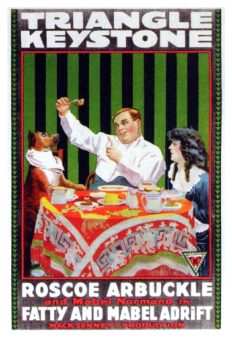

In [0]:
plt.imshow(plt.imread('{}/{}'.format(images_dir, '0006668.jpeg')))
plt.axis('off');

#  1.Movie Poster Classification - Visual Model


### Train a deep learning model to predict the genre

Use transfer learning with and without
fine tuning.

In [0]:
import os
import json
import itertools
import sys
import pickle
import xml.etree.ElementTree as ET
from collections import OrderedDict, Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import (Dense, 
                          GlobalAveragePooling2D,
                          GlobalMaxPool1D,
                          MaxPooling2D,
                          BatchNormalization,
                          Flatten,
                          Dropout,
                          Concatenate,
                          Activation,
                          Bidirectional)
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, model_from_json
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from PIL import Image
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score)

from nltk.corpus import stopwords
import nltk, re, string
from gensim.models import KeyedVectors

In [0]:
!python -m pip install -U keras-preprocessing

Requirement already up-to-date: keras-preprocessing in /usr/local/lib/python3.6/dist-packages (1.1.2)


In [0]:
class Metrics(Callback):
    def __init__(self, validation_generator, validation_steps=None, threshold=0.5):
        self.validation_generator = validation_generator
        self.validation_steps = validation_steps or len(validation_generator)
        self.threshold = threshold

    def on_train_begin(self, logs={}):
        self.dev_f1_weighted_scores = []
        self.dev_binary_crossentropy = []


    def on_epoch_end(self, epoch, logs={}):
        bce = tf.keras.losses.BinaryCrossentropy()
        gen_1, gen_2 = itertools.tee(self.validation_generator)
        y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype("int")
        y_pred_prob = self.model.predict_generator(gen_2, steps=self.validation_steps)
        y_pred = (y_pred_prob> self.threshold).astype("int")

        _dev_f1_weighted = f1_score(y_true, y_pred, average="weighted")
        _dev_f1_micro = f1_score(y_true, y_pred, average="micro")
        _dev_f1_macro = f1_score(y_true, y_pred, average="macro")
        _dev_f1_samples = f1_score(y_true, y_pred, average="samples")
        _dev_loss = bce(y_true.tolist(), y_pred_prob.tolist()).numpy()

        self.dev_f1_weighted_scores.append(_dev_f1_weighted)
        self.dev_binary_crossentropy.append(_dev_loss)

        print(
            f"dev_binary_crossentropy:  {_dev_loss:.5f} - dev_f1_weighted:  {_dev_f1_weighted:.5f} - dev_f1_samples:  {_dev_f1_samples:.5f} - dev_f1_micro:  {_dev_f1_micro:.5f} - dev_f1_macro: {_dev_f1_macro:.5f}"
        )
        return

In [0]:
with open(os.path.join(drive_directory, 'df_splits.pkl'), 'rb') as handle:
    df_splits = pickle.load(handle)

Set partitions of data defined for train/dev/test

In [0]:
data_train = df_splits['train']
data_dev = df_splits['dev']
data_test = df_splits['test']

In [0]:
data_train

,filename,labels,plots
0,0106714.jpeg,"[Crime, Drama, Thriller]",[Mild mannered businessman Anthony Wongs life is shattered when hi...
1,0204504.jpeg,"[Action, Crime, Drama, Thriller]",[Tough girl biker Ako (pop singer Akiko Wada) comes across Mei (Me...
2,1865357.jpeg,[Drama],[Roque starts University in Buenos Aires but he is not particularl...
3,0033804.jpeg,"[Comedy, Romance]","[Returning from a year up the Amazon studying snakes, the rich but..."
4,0066423.jpeg,[Comedy],[Politician get hitch hikers on road and in one car accident they ...
...,...,...,...
15547,0047954.jpeg,[Western],[A pastor with a shady past moves into a rural town just after the...
15548,1245492.jpeg,"[Comedy, Fantasy]","[All, While attending a party at James Franco's house, Seth Rogen,..."
15549,0049061.jpeg,"[Comedy, Drama, Romance]","[At breakfast, Jane announces that she and Ralph are getting marri..."
15550,0104285.jpeg,"[Animation, Short, Comedy, Fantasy]","[BREAKFAST: After eating breakfast, a man is transformed into an e..."


### Preprocesing
Clean Labels that are not in article

In [0]:
def clean_labels(labels):
    labels_article = ['Drama', 'Comedy', 'Romance', 'Thriller', 'Crime', 'Action', 'Adventure', 
                    'Horror', 'Documentary', 'Mystery', 'Sci-Fi', 'Music','Fantasy','Family', 
                    'Biography', 'War', 'History', 'Animation', 'Musical', 'Western', 'Sport',
                    'Short','Film-Noir']
    for label in labels:
        if label not in labels_article:
            labels.remove(label)
    return labels

In [0]:
data_train['labels'] = data_train['labels'].apply(lambda x: clean_labels(x))
data_dev['labels'] = data_dev['labels'].apply(lambda x: clean_labels(x))
data_test['labels'] = data_test['labels'].apply(lambda x: clean_labels(x))

Different classes are represented in the dataset

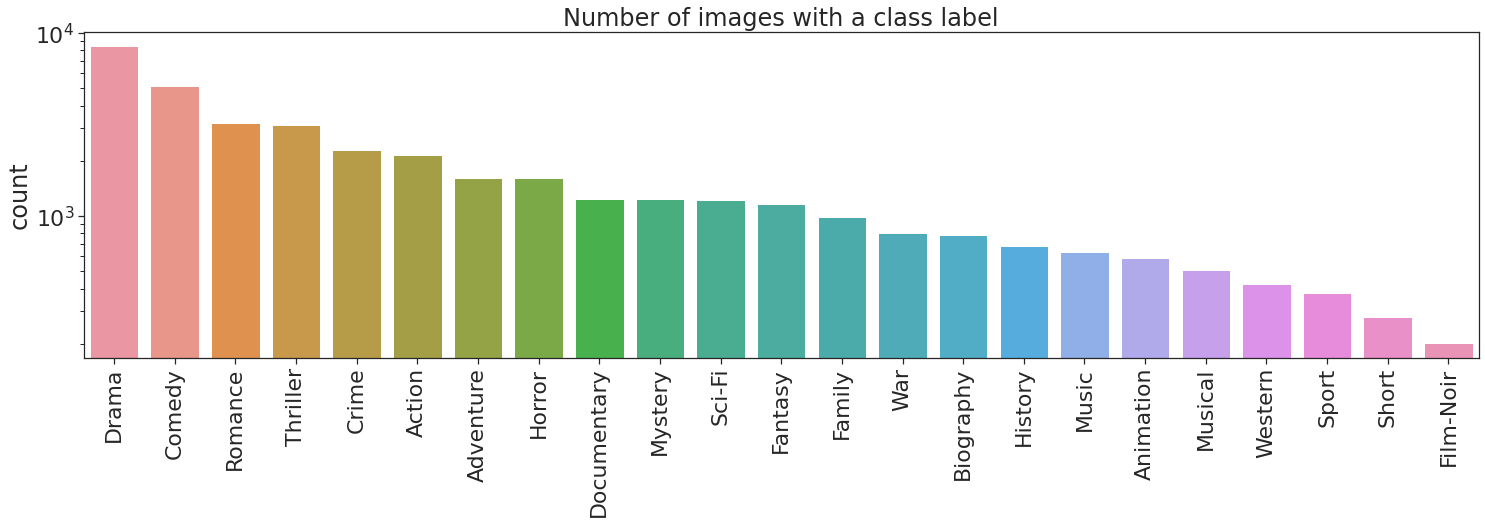

In [0]:
all_labels = [label for lbs in data_train['labels'] for label in lbs]
labels_count = Counter(all_labels)
ax = sns.countplot(all_labels, order=[k for k, _ in labels_count.most_common()], log=True)
ax.set_title('Number of images with a class label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [0]:
images_dir = Path(images_dir).expanduser()

#### Example of poster and their multiple genres labels

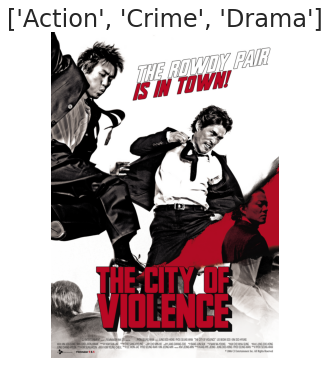

In [0]:
image_directory = Path(images_dir)
observation = data_train.sample(n=1).to_dict(orient='records')[0]
img = plt.imread(images_dir.joinpath(observation['filename']))
plt.imshow(img)
plt.axis('off')
plt.title(observation['labels']);

### Define data generatos 

In [0]:
img_gen = ImageDataGenerator(rescale=1/255)

In [0]:
BATCH_SIZE = 128
img_width, img_height = 224, 224

img_iter_train = img_gen.flow_from_dataframe(
    data_train,
    shuffle=True,
    directory=images_dir,
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE
)

img_iter_dev = img_gen.flow_from_dataframe(
    data_dev,
    shuffle=False,
    directory=images_dir,
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE
)

Found 15552 validated image filenames belonging to 23 classes.
Found 2608 validated image filenames belonging to 23 classes.


In [0]:
img_iter_test = img_gen.flow_from_dataframe(
    data_test,
    shuffle=False,
    directory=images_dir,
    x_col='filename',
    y_col='labels',
    class_mode='categorical',
    target_size=(img_width, img_height),
    batch_size=1
)

Found 7799 validated image filenames belonging to 23 classes.


In [0]:
steps_per_epoch = img_iter_train.n // BATCH_SIZE
validation_steps = img_iter_dev.n // BATCH_SIZE

In [0]:
steps_per_epoch

121

In [0]:
label_to_class = {v: k for k, v in img_iter_train.class_indices.items()}
CLASS_NRB = len(label_to_class)
def array_to_labels(onehot_array, label_to_class):
    labels = []
    idx = np.where(onehot_array == 1)[0]
    return [label_to_class[i] for i in idx]

In [0]:
all_labels = [label for lbs in data_train['labels'] for label in lbs]
labels_count = Counter(all_labels)
total_counts = sum(labels_count.values())
class_weights = {img_iter_train.class_indices[cls]: total_counts / count for cls, count in labels_count.items()}

In [0]:
label_to_class

{0: 'Action',
 1: 'Adventure',
 2: 'Animation',
 3: 'Biography',
 4: 'Comedy',
 5: 'Crime',
 6: 'Documentary',
 7: 'Drama',
 8: 'Family',
 9: 'Fantasy',
 10: 'Film-Noir',
 11: 'History',
 12: 'Horror',
 13: 'Music',
 14: 'Musical',
 15: 'Mystery',
 16: 'Romance',
 17: 'Sci-Fi',
 18: 'Short',
 19: 'Sport',
 20: 'Thriller',
 21: 'War',
 22: 'Western'}

In [0]:
total_counts = sum(labels_count.values())
class_weights = {img_iter_train.class_indices[cls]: total_counts / count for cls, count in labels_count.items()}
class_weights

{0: 17.926682134570765,
 1: 23.980136561142146,
 2: 65.92491467576792,
 3: 49.025380710659896,
 4: 7.563038371182459,
 5: 16.84779764500654,
 6: 31.306320907617504,
 7: 4.585944919278252,
 8: 39.50102249488753,
 9: 33.246127366609294,
 10: 191.24752475247524,
 11: 56.811764705882354,
 12: 24.099812850904556,
 13: 60.93375394321767,
 14: 76.80318091451292,
 15: 31.382615759545086,
 16: 11.975201487910725,
 17: 31.874587458745875,
 18: 137.48042704626334,
 19: 101.93139841688654,
 20: 12.409893992932862,
 21: 47.930521091811414,
 22: 91.32860520094563}

## 1.1 Transfer Learning



In [0]:
input_size = 224
EPOCHS = 100

VGG Network feature extractor

In [0]:
# Try with VGG Network 
base_model = VGG16(weights='imagenet', 
                   include_top=True,
                   input_shape=(input_size,input_size,3))

# Freeze the feature extractor (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

base_model = Model(base_model.input, base_model.layers[-2].output) # Remove decision layers
batchnorm1 = BatchNormalization()(base_model.output)
dropout1 = Dropout(0.5)(batchnorm1)
dense1 = Dense(512, activation='relu')(dropout1)
batchnorm2 = BatchNormalization()(dense1)
dense2 = Dense(CLASS_NRB, activation='sigmoid')(batchnorm2)  # Sigmoid - probability of each label is independent
model_visual = Model(inputs=base_model.input, outputs=dense2)

553467904/553467096 [==============================] - 13s 0us/step


In [0]:
model_visual.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.01),
    metrics=[tf.keras.losses.BinaryCrossentropy()]
)

model_visual.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
early_stopping_monitor = EarlyStopping(
    monitor='binary_crossentropy',
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
    )

In [0]:
metrics = Metrics(img_iter_dev, validation_steps=validation_steps)
history = model_visual.fit_generator(
    img_iter_train,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights,
    callbacks=[metrics, early_stopping_monitor],
    verbose=1
)

Epoch 1/100
  2/121 [..............................] - ETA: 8:59 - loss: 2.8268 - binary_crossentropy: 0.2080 

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97965244 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 23/121 [====>.........................] - ETA: 4:38 - loss: 3.0461 - binary_crossentropy: 0.2197

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99331758 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 28/121 [=====>........................] - ETA: 4:22 - loss: 3.0862 - binary_crossentropy: 0.2213

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 33/121 [=======>......................] - ETA: 4:12 - loss: 3.0812 - binary_crossentropy: 0.2232

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97888494 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 44/121 [=========>....................] - ETA: 3:40 - loss: 3.1002 - binary_crossentropy: 0.2231

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97212000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 60/121 [=============>................] - ETA: 2:55 - loss: 3.1120 - binary_crossentropy: 0.2235

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (174960000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 66/121 [===============>..............] - ETA: 2:38 - loss: 3.1197 - binary_crossentropy: 0.2227

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96592500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 72/121 [================>.............] - ETA: 2:23 - loss: 3.1166 - binary_crossentropy: 0.2228

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 73/121 [=================>............] - ETA: 2:21 - loss: 3.1189 - binary_crossentropy: 0.2229

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 78/121 [==================>...........] - ETA: 2:05 - loss: 3.1204 - binary_crossentropy: 0.2229

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 82/121 [===================>..........] - ETA: 1:54 - loss: 3.1260 - binary_crossentropy: 0.2233

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 83/121 [===================>..........] - ETA: 1:52 - loss: 3.1299 - binary_crossentropy: 0.2236

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94770000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


109/121 [==========================>...] - ETA: 34s - loss: 3.1390 - binary_crossentropy: 0.2241

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


111/121 [==========================>...] - ETA: 28s - loss: 3.1405 - binary_crossentropy: 0.2243

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


121/121 [==============================] - 342s 3s/step - loss: 3.1488 - binary_crossentropy: 0.2245


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


dev_binary_crossentropy:  0.33013 - dev_f1_weighted:  0.28527 - dev_f1_samples:  0.25973 - dev_f1_micro:  0.29675 - dev_f1_macro: 0.18303
Epoch 2/100
121/121 [==============================] - 306s 3s/step - loss: 2.9970 - binary_crossentropy: 0.2177
dev_binary_crossentropy:  0.32740 - dev_f1_weighted:  0.28959 - dev_f1_samples:  0.27209 - dev_f1_micro:  0.30309 - dev_f1_macro: 0.18338
Epoch 3/100
121/121 [==============================] - 307s 3s/step - loss: 2.9776 - binary_crossentropy: 0.2153
dev_binary_crossentropy:  0.32661 - dev_f1_weighted:  0.32114 - dev_f1_samples:  0.32015 - dev_f1_micro:  0.34711 - dev_f1_macro: 0.18477
Epoch 4/100
121/121 [==============================] - 299s 2s/step - loss: 2.9007 - binary_crossentropy: 0.2129
dev_binary_crossentropy:  0.33359 - dev_f1_weighted:  0.31019 - dev_f1_samples:  0.30099 - dev_f1_micro:  0.33018 - dev_f1_macro: 0.18469
Epoch 5/100
121/121 [==============================] - 301s 2s/step - loss: 2.8701 - binary_crossentropy: 0.2

In [0]:
# serialize model to JSON
model_json = model_visual.to_json()
with open("visual_transfer_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_visual.save_weights("visual_transfer_model.h5")
print("Saved model to disk")

# Save to drive
h5_file_name = "visual_transfer_model.h5"
json_file_name = "visual_transfer_model.json"
save_file_to_drive(h5_file_name, h5_file_name)
save_file_to_drive(json_file_name, json_file_name)

Saved model to disk
File ID: 1wvGfDfQXypQJY47Zrap4KJkFbUp9x3Qp
File ID: 137HSfT1o9NyaGBi3jBDXRULJZfHWIdy_


{'id': '137HSfT1o9NyaGBi3jBDXRULJZfHWIdy_'}

In [0]:
"""
# load json and create model
json_file = open(os.path.join(drive_directory, 'visual_transfer_model.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
model_visual = model_from_json(loaded_model_json)
# load weights into new model
model_visual.load_weights(os.path.join(drive_directory, "visual_transfer_model.h5"))
print("Loaded model from disk")
"""

'\n# load json and create model\njson_file = open(os.path.join(drive_directory, \'visual_transfer_model.json\'), \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nmodel_visual = model_from_json(loaded_model_json)\n# load weights into new model\nmodel_visual.load_weights("visual_transfer_model.h5")\nprint("Loaded model from disk")\n'

#### Metrics on Test set

In [0]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(img_iter_test, 2)
y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(img_iter_test.n)).astype('int')
y_pred_prob_visual = model_visual.predict_generator(img_iter_test, steps = img_iter_test.n)
y_pred = (y_pred_prob_visual> threshold).astype('int')

test_f1_weighted = f1_score(y_true, y_pred, average='weighted')
test_f1_micro = f1_score(y_true, y_pred, average='micro')
test_f1_macro = f1_score(y_true, y_pred, average='macro')
test_f1_samples = f1_score(y_true, y_pred, average='samples')
print(f" - test_f1_weighted:  {test_f1_weighted:.5f} - test_f1_samples:  {test_f1_samples:.5f} - test_f1_micro:  {test_f1_micro:.5f} - test_f1_macro: {test_f1_macro:.5f}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (92984898 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarn

 - test_f1_weighted:  0.30281 - test_f1_samples:  0.28464 - test_f1_micro:  0.31547 - test_f1_macro: 0.18806


#### Calculate Macro F score By Genres 

In [0]:
for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
    tn, fp, fn, tp = conf_matrix.ravel()
    f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
    recall = tp / (tp + fn + sys.float_info.epsilon)
    print(f'Label: {label_to_class[i]} f1={f1:.5f}')

Label: Action f1=0.24510
Label: Adventure f1=0.19659
Label: Animation f1=0.36290
Label: Biography f1=0.03846
Label: Comedy f1=0.48235
Label: Crime f1=0.16819
Label: Documentary f1=0.17641
Label: Drama f1=0.51571
Label: Family f1=0.28040
Label: Fantasy f1=0.11097
Label: Film-Noir f1=0.08955
Label: History f1=0.01504
Label: Horror f1=0.20030
Label: Music f1=0.01153
Label: Musical f1=0.07717
Label: Mystery f1=0.13062
Label: Romance f1=0.24536
Label: Sci-Fi f1=0.20963
Label: Short f1=0.18100
Label: Sport f1=0.03077
Label: Thriller f1=0.33721
Label: War f1=0.03486
Label: Western f1=0.18526


#### Example Predictions on a Poster 


True labels: ['Action', 'Crime', 'Drama', 'Thriller']
Predicted labels: ['Drama', 'Thriller']


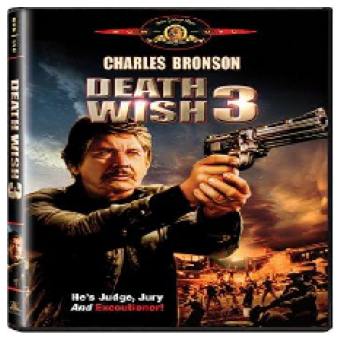

In [0]:
images, labels = next(img_iter_test)
plt.imshow(np.hstack(images[:3]))
labels_pred = model_visual.predict(images)
for i in range(0, len(labels_pred)):
    labels_pred[i] = np.where(labels_pred[i] > 0.5, 1, 0)
predicted = (' ' * 5).join(str(array_to_labels(x, label_to_class)) for x in labels_pred[:3])
gt = ('-' * 5).join(str(array_to_labels(x, label_to_class)) for x in labels[:3])
print('True labels: {}'.format(gt))
print('Predicted labels: {}'.format(predicted))
plt.axis('off');

## 1.2 Fine tunning 

In [0]:
extractor = VGG16(weights='imagenet', 
                   include_top=True,
                   input_shape=(input_size, input_size,3))

extractor.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Warmup
First we do a warmup training only the top layers:

In [0]:
# Freeze the feature extractor (transfer learning)
for layer in extractor.layers:
    layer.trainable=False

base_model = Model(extractor.input, extractor.layers[-2].output) # Remove decision layer
x4 = BatchNormalization()(base_model.output)
x3 = Dropout(0.5)(x4)
x1 = Dense(512, activation='relu')(x3)
x0 = BatchNormalization()(x1)
x = Dense(CLASS_NRB, activation='sigmoid')(x0)

tl_model = Model(inputs=base_model.input, outputs=x)

tl_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=1e-3),
    metrics=[tf.keras.losses.BinaryCrossentropy()]
)

In [0]:
metrics = Metrics(img_iter_dev, validation_steps=validation_steps)
tl_model.fit_generator(
    img_iter_train,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights,
    callbacks=[metrics])

Epoch 1/20
  5/121 [>.............................] - ETA: 5:18 - loss: 5.1862 - binary_crossentropy: 0.3217

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97888494 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  9/121 [=>............................] - ETA: 4:57 - loss: 5.3025 - binary_crossentropy: 0.3177

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96592500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 13/121 [==>...........................] - ETA: 5:08 - loss: 5.2605 - binary_crossentropy: 0.3143

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94770000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 25/121 [=====>........................] - ETA: 4:15 - loss: 5.2575 - binary_crossentropy: 0.3093

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97965244 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 31/121 [======>.......................] - ETA: 4:09 - loss: 5.2120 - binary_crossentropy: 0.3068

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 69/121 [================>.............] - ETA: 2:16 - loss: 5.0503 - binary_crossentropy: 0.2956

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 82/121 [===================>..........] - ETA: 1:44 - loss: 5.0511 - binary_crossentropy: 0.2934

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 83/121 [===================>..........] - ETA: 1:42 - loss: 5.0473 - binary_crossentropy: 0.2933

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 89/121 [=====================>........] - ETA: 1:26 - loss: 5.0503 - binary_crossentropy: 0.2929

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97212000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


108/121 [=========================>....] - ETA: 34s - loss: 5.0609 - binary_crossentropy: 0.2910

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


113/121 [===========================>..] - ETA: 21s - loss: 5.0686 - binary_crossentropy: 0.2905

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (174960000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99331758 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


117/121 [============================>.] - ETA: 10s - loss: 5.0770 - binary_crossentropy: 0.2905

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


121/121 [==============================] - 329s 3s/step - loss: 5.0577 - binary_crossentropy: 0.2899


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


dev_binary_crossentropy:  0.27565 - dev_f1_weighted:  0.13835 - dev_f1_samples:  0.15450 - dev_f1_micro:  0.17467 - dev_f1_macro: 0.03857
Epoch 2/20
121/121 [==============================] - 325s 3s/step - loss: 4.7972 - binary_crossentropy: 0.2741
dev_binary_crossentropy:  0.27349 - dev_f1_weighted:  0.18326 - dev_f1_samples:  0.19835 - dev_f1_micro:  0.22339 - dev_f1_macro: 0.07194
Epoch 3/20
121/121 [==============================] - 322s 3s/step - loss: 4.6769 - binary_crossentropy: 0.2693
dev_binary_crossentropy:  0.27843 - dev_f1_weighted:  0.19963 - dev_f1_samples:  0.19613 - dev_f1_micro:  0.22860 - dev_f1_macro: 0.10506
Epoch 4/20
121/121 [==============================] - 322s 3s/step - loss: 4.5572 - binary_crossentropy: 0.2663
dev_binary_crossentropy:  0.27556 - dev_f1_weighted:  0.22269 - dev_f1_samples:  0.21437 - dev_f1_micro:  0.25187 - dev_f1_macro: 0.12482
Epoch 5/20
121/121 [==============================] - 319s 3s/step - loss: 4.4963 - binary_crossentropy: 0.2633


#### Unfreeze the extractor layers:
- Allow some of the layers to train with a reduced learning rate  

In [0]:
# Unfreeze the extractor layers
for layer in tl_model.layers[-5:]:
    layer.trainable = True

# change the learning rate
tl_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(lr=1e-5),
    metrics=[tf.keras.losses.BinaryCrossentropy()]
)

metrics = Metrics(img_iter_dev, validation_steps=validation_steps)
# train
history = tl_model.fit_generator(
    img_iter_train,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights, 
    callbacks=[metrics])

Epoch 1/5
  4/121 [..............................] - ETA: 5:04 - loss: 3.2728 - binary_crossentropy: 0.2240

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (174960000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


  9/121 [=>............................] - ETA: 4:26 - loss: 3.1533 - binary_crossentropy: 0.2173

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (95616768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 10/121 [=>............................] - ETA: 4:46 - loss: 3.1567 - binary_crossentropy: 0.2170

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97965244 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 23/121 [====>.........................] - ETA: 4:12 - loss: 3.2686 - binary_crossentropy: 0.2233

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 39/121 [========>.....................] - ETA: 3:23 - loss: 3.3084 - binary_crossentropy: 0.2245

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99331758 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 68/121 [===============>..............] - ETA: 2:16 - loss: 3.3277 - binary_crossentropy: 0.2242

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97143904 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 71/121 [================>.............] - ETA: 2:11 - loss: 3.3263 - binary_crossentropy: 0.2242

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 83/121 [===================>..........] - ETA: 1:39 - loss: 3.2990 - binary_crossentropy: 0.2240

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97888494 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


 95/121 [======================>.......] - ETA: 1:08 - loss: 3.3050 - binary_crossentropy: 0.2234

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97212000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


103/121 [========================>.....] - ETA: 47s - loss: 3.3039 - binary_crossentropy: 0.2234

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94770000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


106/121 [=========================>....] - ETA: 39s - loss: 3.2976 - binary_crossentropy: 0.2231

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96592500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


109/121 [==========================>...] - ETA: 31s - loss: 3.3019 - binary_crossentropy: 0.2230

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97778814 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


110/121 [==========================>...] - ETA: 29s - loss: 3.3032 - binary_crossentropy: 0.2230

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (100233700 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


120/121 [============================>.] - ETA: 2s - loss: 3.2938 - binary_crossentropy: 0.2229

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


121/121 [==============================] - 322s 3s/step - loss: 3.2919 - binary_crossentropy: 0.2229


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  from ipykernel import kernelapp as app


dev_binary_crossentropy:  0.29114 - dev_f1_weighted:  0.27553 - dev_f1_samples:  0.26676 - dev_f1_micro:  0.30262 - dev_f1_macro: 0.16378
Epoch 2/5
121/121 [==============================] - 312s 3s/step - loss: 3.2731 - binary_crossentropy: 0.2220
dev_binary_crossentropy:  0.29010 - dev_f1_weighted:  0.27850 - dev_f1_samples:  0.26918 - dev_f1_micro:  0.30501 - dev_f1_macro: 0.16347
Epoch 3/5
121/121 [==============================] - 310s 3s/step - loss: 3.2490 - binary_crossentropy: 0.2209
dev_binary_crossentropy:  0.28937 - dev_f1_weighted:  0.28322 - dev_f1_samples:  0.27353 - dev_f1_micro:  0.30985 - dev_f1_macro: 0.16648
Epoch 4/5
121/121 [==============================] - 303s 3s/step - loss: 3.2520 - binary_crossentropy: 0.2201
dev_binary_crossentropy:  0.28905 - dev_f1_weighted:  0.28500 - dev_f1_samples:  0.27561 - dev_f1_micro:  0.31129 - dev_f1_macro: 0.16648
Epoch 5/5
121/121 [==============================] - 296s 2s/step - loss: 3.2400 - binary_crossentropy: 0.2205
dev_

In [0]:
# serialize model to JSON
model_json = model_visual.to_json()
with open("visual_fine_tune_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_visual.save_weights("visual_fine_tune_model.h5")
print("Saved model to disk")

# Save to drive
h5_file_name = "visual_fine_tune_model.h5"
json_file_name = "visual_fine_tune_model.json"
save_file_to_drive(h5_file_name, h5_file_name)
save_file_to_drive(json_file_name, json_file_name)

Saved model to disk
File ID: 1NW5yjH_vMPFPh8GqELejBhHNY7EdHJvc
File ID: 1O03cPlkaLRd4ZF6LnanmxPNdXUTE4_aB


{'id': '1O03cPlkaLRd4ZF6LnanmxPNdXUTE4_aB'}

#### Metrics on Test set

In [0]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(img_iter_test, 2)
y_true = np.vstack(next(img_iter_val_0)[1] for _ in range(img_iter_test.n)).astype('int')
y_pred_prob_visual = tl_model.predict_generator(img_iter_test, steps = img_iter_test.n)
y_pred = (y_pred_prob_visual> threshold).astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99083998 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (92984898 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarn

In [0]:
test_f1_weighted = f1_score(y_true, y_pred, average='weighted')
test_f1_micro = f1_score(y_true, y_pred, average='micro')
test_f1_macro = f1_score(y_true, y_pred, average='macro')
test_f1_samples = f1_score(y_true, y_pred, average='samples')
print(f" - test_f1_weighted:  {test_f1_weighted:.5f} - test_f1_samples:  {test_f1_samples:.5f} - test_f1_micro:  {test_f1_micro:.5f} - test_f1_macro: {test_f1_macro:.5f}")

 - test_f1_weighted:  0.15710 - test_f1_samples:  0.15950 - test_f1_micro:  0.17769 - test_f1_macro: 0.05806


#### Calculate Macro F score By Genres 

In [0]:
for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
    tn, fp, fn, tp = conf_matrix.ravel()
    f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
    recall = tp / (tp + fn + sys.float_info.epsilon)
    print(f'Label: {label_to_class[i]} f1={f1:.5f}')

Label: Action f1=0.09273
Label: Adventure f1=0.03989
Label: Animation f1=0.03303
Label: Biography f1=0.03617
Label: Comedy f1=0.21956
Label: Crime f1=0.06644
Label: Documentary f1=0.04837
Label: Drama f1=0.43956
Label: Family f1=0.03179
Label: Fantasy f1=0.03972
Label: Film-Noir f1=0.00000
Label: History f1=0.00545
Label: Horror f1=0.03025
Label: Music f1=0.00000
Label: Musical f1=0.00692
Label: Mystery f1=0.00909
Label: Romance f1=0.06172
Label: Sci-Fi f1=0.03557
Label: Short f1=0.00000
Label: Sport f1=0.00000
Label: Thriller f1=0.12070
Label: War f1=0.00482
Label: Western f1=0.01361


#### Example Predictions on a Poster

True labels: ['Documentary']
Predicted labels: ['Sci-Fi']


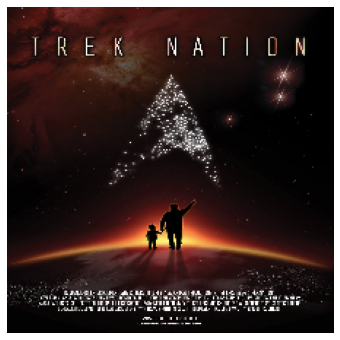

In [0]:
images, labels = next(img_iter_test)
plt.imshow(np.hstack(images[:3]))
labels_pred = tl_model.predict(images)
for i in range(0, len(labels_pred)):
    labels_pred[i] = np.where(labels_pred[i] > 0.5, 1, 0)
predicted = (' ' * 5).join(str(array_to_labels(x, label_to_class)) for x in labels_pred[:3])
gt = ('-' * 5).join(str(array_to_labels(x, label_to_class)) for x in labels[:3])
print('True labels: {}'.format(gt))
print('Predicted labels: {}'.format(predicted))
plt.axis('off');

## 1.3 Evaluate and analyze the results. 
Use the same evaluation metrics reported in the original paper. Compare your results with the ones reported in the paper. Discuss the results.

| Modality |                | Representation  | f1_weighted | f1_samples | f1_micro | f1_macro |
|----------|----------------|-----------------|-------------|------------|----------|----------|
| Visual   | Arevalo et al. | VGG_Transfer    | **0.410**       | **0.429**      | **0.437**    | **0.284**    |
|          |                | CNN_end2end     | 0.372       | 0.350      | 0.340    | 0.210    |
| Visual   | Ours           | VGG_Transfer    | 0.30281     | 0.28464    | 0.31547  | 0.18806  |
|          |                | VGG_fine_tuning | 0.15710     | 0.15950    | 0.17769  | 0.05806  |

**Discuss:**  For the visual model *Arevalo et a*l metrics are better even when in this work we tried to replicate their approach for transfer learning. This could be explained by the amount of epochs of 200 in Arevalo’s code vs much less in our approach. We can also point out that the worst metrics are from the fine tuning approach, this might be because when we unfreeze some layers and start the training the network might ‘forget’ what have learned before and might need a much more iterations to learn again from this new dataset. Also this dataset is small compared with the ones of naturales images usually used.  

# 2.Movie synopsis classification - Text Model

In [0]:
nltk.download('stopwords')

def preprocessing(doc):
    letters_only = re.sub("[^a-zA-Z]", " ",doc) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))  
    meaningful_words =  [word for word in words if not word in stops]
    return( " ".join( meaningful_words ))

data_train['plots'] = data_train['plots'].apply(lambda x: preprocessing(x[0]))
data_dev['plots'] = data_dev['plots'].apply(lambda x: preprocessing(x[0]))
data_test['plots'] = data_test['plots'].apply(lambda x: preprocessing(x[0]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df = pd.concat([data_dev, data_test, data_train], ignore_index=True)

(array([1.2293e+04, 1.0537e+04, 2.1200e+03, 6.9100e+02, 2.1300e+02,
        5.9000e+01, 2.5000e+01, 9.0000e+00, 6.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  0. ,  39.3,  78.6, 117.9, 157.2, 196.5, 235.8, 275.1, 314.4,
        353.7, 393. , 432.3, 471.6, 510.9, 550.2, 589.5, 628.8, 668.1,
        707.4, 746.7, 786. ]),
 <a list of 20 Patch objects>)

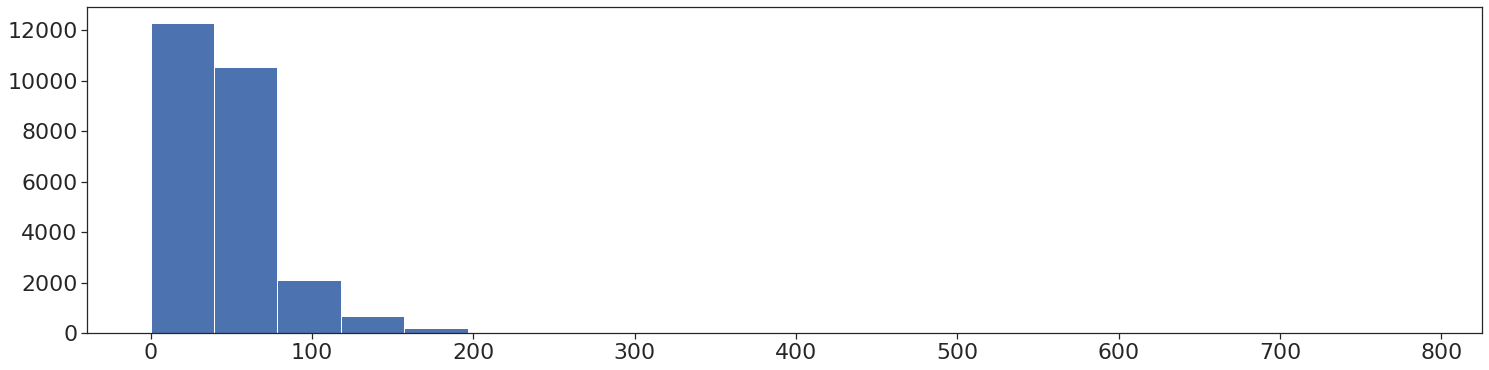

In [0]:
sent = df['plots'].tolist()
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sent)

len_list = []
for a in sent:
    len_list.append(len(a.split()))

plt.hist(len_list, bins=20)

Clean Plots 

In [0]:
from nltk.corpus import stopwords
import nltk, re, string
nltk.download('stopwords')

def preprocessing(doc):
    letters_only = re.sub("[^a-zA-Z]", " ",doc) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))  
    meaningful_words =  [word for word in words if not word in stops
                                                and word != 'find'
                                                and word != 'one'
                                                and word != 'life'
                                                and word != 'man'
                                                and word != 'young'
                                                and word != 'two'
                                                and word != 'family'
                                                and word != 'friend'
                                                and word != 'friends'
                                                and word != 'father' ]                                                
    return( " ".join( meaningful_words ))
#add x[0] in concatenation
data_train['plots'] = data_train['plots'].apply(lambda x: preprocessing(x))
data_dev['plots'] = data_dev['plots'].apply(lambda x: preprocessing(x))
data_test['plots'] = data_test['plots'].apply(lambda x: preprocessing(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
data_train['plots']

0        mild mannered businessman anthony wongs shattered pregnant wife ru...
1        tough girl biker ako pop singer akiko wada comes across mei meiko ...
2        roque starts university buenos aires particularly interested atten...
3        returning year amazon studying snakes rich unsophisticated charles...
4                   politician get hitch hikers road car accident end tree sea
                                         ...                                  
15547                             pastor shady past moves rural town civil war
15548                                                                         
15549    breakfast jane announces ralph getting married next week jane ralp...
15550    breakfast eating breakfast transformed elaborate dumb waiter style...
15551    passes away four grown siblings bruised banged respective adult li...
Name: plots, Length: 15552, dtype: object

In [0]:
le = MultiLabelBinarizer()

labels_article = ['Drama', 'Comedy', 'Romance', 'Thriller', 'Crime', 'Action', 'Adventure', 
                    'Horror', 'Documentary', 'Mystery', 'Sci-Fi', 'Music','Fantasy','Family', 
                    'Biography', 'War', 'History', 'Animation', 'Musical', 'Western', 'Sport',
                    'Short','Film-Noir']

le.fit([labels_article])

data_train['labels_several_hot'] = data_train['labels'].apply(lambda x: le.transform([x])[0].tolist())
data_dev['labels_several_hot'] = data_dev['labels'].apply(lambda x: le.transform([x])[0].tolist())
data_test['labels_several_hot'] = data_test['labels'].apply(lambda x:  le.transform([x])[0].tolist())

Embedding word2vec 

In [0]:
EMBEDDING_FILE = drive_directory + '/GoogleNews-vectors-negative300.bin.gz'

In [0]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Create Vocabulary

In [0]:
df = pd.concat([data_dev, data_test, data_train], ignore_index=True)

max_length = 0
vocab_counts = []
for idx, row in df.iterrows():
  max_length = max(len(df['plots'][idx]), max_length)
  vocab_counts.extend(df['plots'][idx].split(' '))

vocab_counts = OrderedDict(Counter(vocab_counts).most_common())
vocab = ['_UNK_'] + [v for v in vocab_counts.keys()]

Data Preparation

In [0]:
ix_to_word = dict(zip(range(len(vocab)), vocab))
word_to_ix = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((len(vocab), 300))
for word, i in word_to_ix.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]

vocab_size, emdedding_size = embedding_matrix.shape

(array([1.2888e+04, 1.0222e+04, 1.8940e+03, 6.6700e+02, 1.9000e+02,
        5.7000e+01, 2.1000e+01, 9.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  1. ,  39.6,  78.2, 116.8, 155.4, 194. , 232.6, 271.2, 309.8,
        348.4, 387. , 425.6, 464.2, 502.8, 541.4, 580. , 618.6, 657.2,
        695.8, 734.4, 773. ]),
 <a list of 20 Patch objects>)

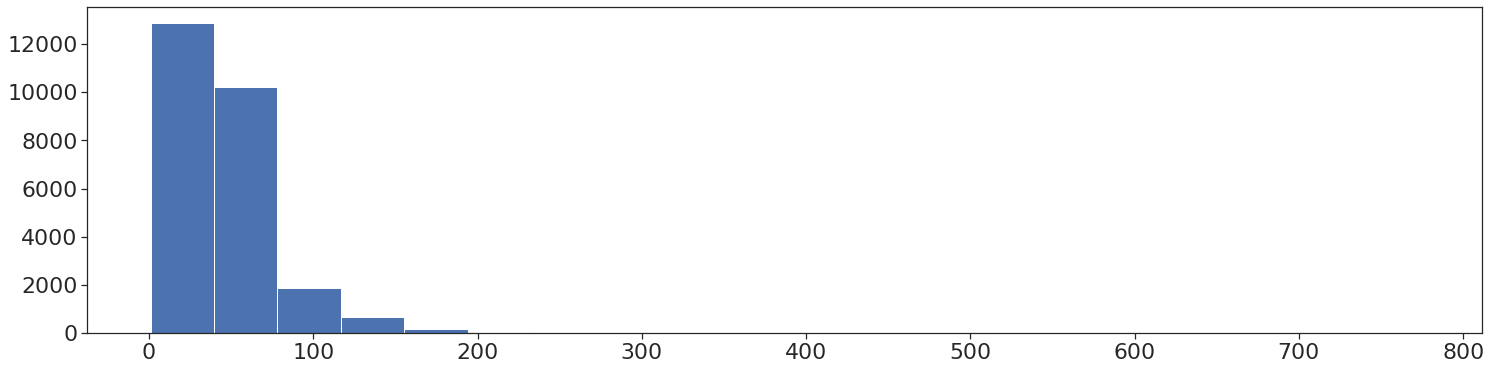

In [0]:
def sequences_plots(data_frame):
    sequences = []
    for idx, row in data_frame.iterrows():
        words = data_frame['plots'][idx].split(' ')
        sequences.append([word_to_ix[w] if w in vocab else unk_idx for w in words])
    return sequences

sequence_train=sequences_plots(data_train)
sequence_dev=sequences_plots(data_dev)
sequence_test=sequences_plots(data_test)

length_tr=[len(i) for i in sequence_train]
length_dv=[len(i) for i in sequence_dev]
length_tst=[len(i) for i in sequence_test]
length_data= length_tr + length_dv + length_tst
max_length_=max(length_data)

plt.hist([length_data],bins=20)

(array([ 683., 1922., 2391., 3139., 3056., 2914., 2399., 2082., 1917.,
        1563.,  935.,  606.,  458.,  351.,  264.,  219.,  191.,  161.,
         148.,  101.]),
 array([  1.  ,   7.95,  14.9 ,  21.85,  28.8 ,  35.75,  42.7 ,  49.65,
         56.6 ,  63.55,  70.5 ,  77.45,  84.4 ,  91.35,  98.3 , 105.25,
        112.2 , 119.15, 126.1 , 133.05, 140.  ]),
 <a list of 20 Patch objects>)

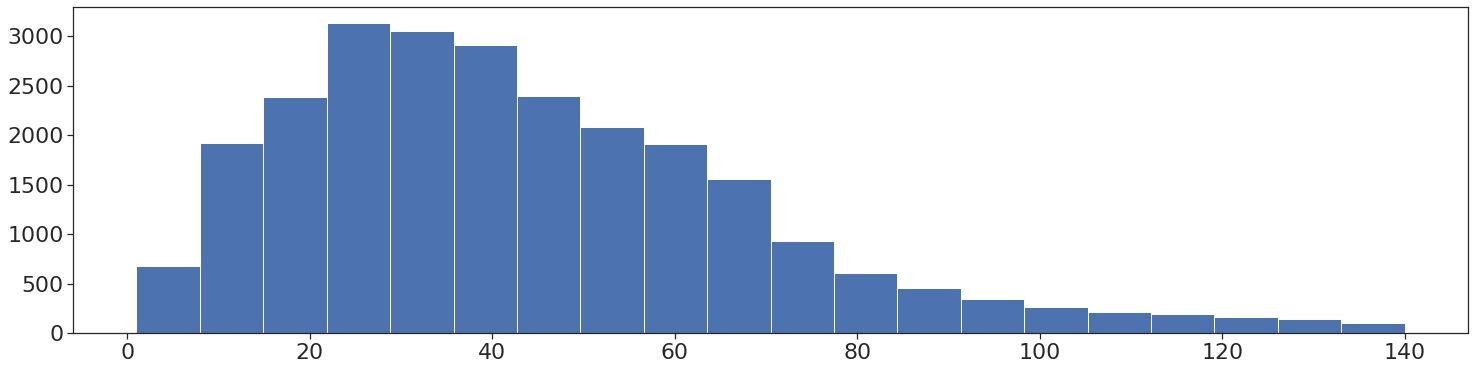

In [0]:
length_data.sort()
plt.hist([length_data[:25500]],bins=20)

In [0]:
y_train_ = data_train['labels_several_hot'].tolist()
y_val_ = data_dev['labels_several_hot'].tolist()
y_test_ = data_test['labels_several_hot'].tolist()

In [0]:
def slidingWindow(sequence,winSize,step):
    """Returns a generator that will iterate through
       the defined chunks of input sequence. Input sequence
       must be sliceable."""
    
    # Pre-compute number of chunks to emit
    numOfChunks = round(((len(sequence)-winSize)/step)+1)

    # Do the work
    for i in range(0,numOfChunks*step,step):
        yield sequence[i:i+winSize]

In [0]:
y_train = np.array(y_train_)
y_val = np.array(y_val_)
y_test = np.array(y_test_)

In [0]:
weigth={}
val=[sum(i) for i in zip(*y_train)]
l=min(val)
for i in range(len(y_train[0])):
  weigth[i]=val[i]/l

In [0]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(sequence_train, maxlen=30, padding='post')
x_val = pad_sequences(sequence_dev, maxlen=30, padding='post')
x_test = pad_sequences(sequence_test, maxlen=30, padding='post')

### 2.1 Train a recurrent neural network 
over the movie synopsis texts to predict the movie genre

Create LSTM

In [0]:
model_text = Sequential()
model_text.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, 
                    weights=[embedding_matrix],trainable=False,input_length=30))
model_text.add(Bidirectional(LSTM(units=40, return_sequences=True, dropout_U = 0.05, dropout_W = 0.05)))
model_text.add(GlobalMaxPool1D())
model_text.add(Dropout(0.1))
model_text.add(Dense(100))
model_text.add(Activation('relu'))
model_text.add(Dropout(0.1))
model_text.add(Dense(300))
model_text.add(Activation('relu'))
model_text.add(Dropout(0.1))
model_text.add(Dense(512))
model_text.add(Activation('relu'))
model_text.add(Dropout(0.1))
model_text.add(Dense(units=len(labels_article)))
model_text.add(Activation('sigmoid'))
model_text.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.losses.BinaryCrossentropy()])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=40, return_sequences=True, dropout=0.05, recurrent_dropout=0.05)`
  after removing the cwd from sys.path.


In [0]:
model_text.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           18720600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 80)            109120    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 80)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               8100      
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

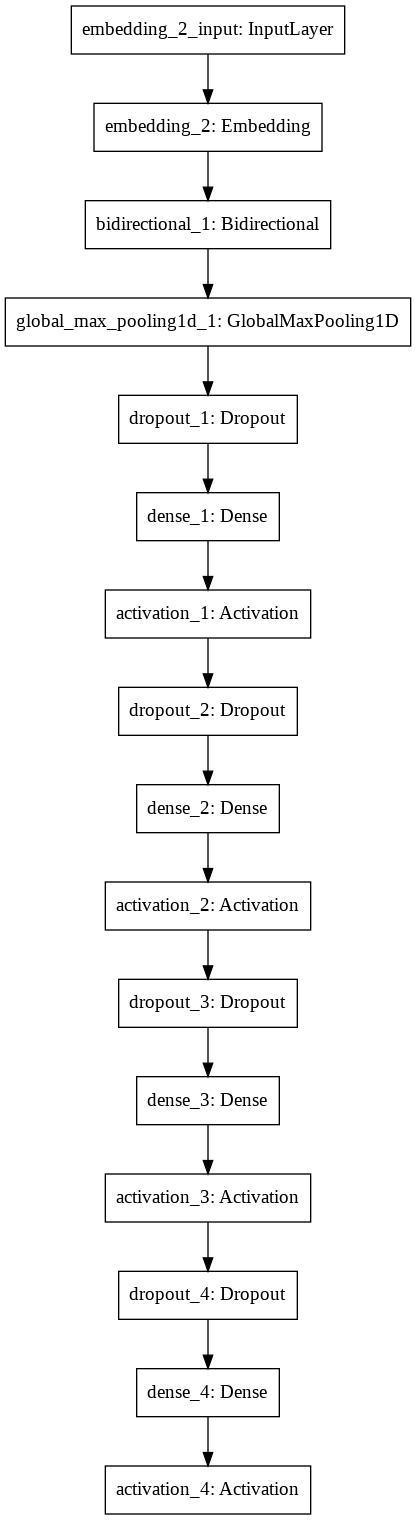

In [0]:
import tensorflow.keras.utils as Draw

Draw.plot_model(model_text)

In [0]:
model_text.fit(x_train, 
               y_train, 
               class_weight=class_weights, 
               batch_size=128, 
               validation_data=(x_val, y_val), 
               epochs=20, 
               verbose=1)

Train on 15552 samples, validate on 2608 samples
Epoch 1/20
15552/15552 [==============================] - 18s 1ms/step - loss: 5.8512 - binary_crossentropy: 0.3235 - val_loss: 0.2879 - val_binary_crossentropy: 0.2879
Epoch 2/20
15552/15552 [==============================] - 17s 1ms/step - loss: 4.7833 - binary_crossentropy: 0.2657 - val_loss: 0.2533 - val_binary_crossentropy: 0.2532
Epoch 3/20
15552/15552 [==============================] - 17s 1ms/step - loss: 4.2649 - binary_crossentropy: 0.2427 - val_loss: 0.2326 - val_binary_crossentropy: 0.2324
Epoch 4/20
15552/15552 [==============================] - 17s 1ms/step - loss: 4.0600 - binary_crossentropy: 0.2337 - val_loss: 0.2271 - val_binary_crossentropy: 0.2267
Epoch 5/20
15552/15552 [==============================] - 17s 1ms/step - loss: 3.8862 - binary_crossentropy: 0.2270 - val_loss: 0.2271 - val_binary_crossentropy: 0.2269
Epoch 6/20
15552/15552 [==============================] - 17s 1ms/step - loss: 3.7602 - binary_crossentrop

In [0]:
# Save Textual model 
# serialize model to JSON
model_text_json = model_text.to_json()
with open("text_model.json", "w") as json_file:
    json_file.write(model_text_json)
# serialize weights to HDF5
model_text.save_weights("text_model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
# Save to drive
h5_file_name = "text_model.h5"
json_file_name = "text_model.json"
save_file_to_drive(h5_file_name, h5_file_name)
save_file_to_drive(json_file_name, json_file_name)

File ID: 1oJElPaknK8kG7iDdF1ki0J7zyktlWXSF
File ID: 12KQMRg3Egq5ndKwNihog9QTLZy27tHje


{'id': '12KQMRg3Egq5ndKwNihog9QTLZy27tHje'}

### 2.2 Evaluate and analyze the results. 
Compare your results with the ones reported in the paper. Discuss the results.

#### Metrics on Test 

In [0]:
threshold = 0.5
y_pred_prob_text = model_text.predict(x_test)
y_true_test = y_test
y_pred = (y_pred_prob_text> threshold).astype('int')

In [0]:
test_f1_weighted = f1_score(y_true_test, y_pred, average='weighted')
test_f1_micro = f1_score(y_true_test, y_pred, average='micro')
test_f1_macro = f1_score(y_true_test, y_pred, average='macro')
test_f1_samples = f1_score(y_true_test, y_pred, average='samples')
print(f" - test_f1_weighted:  {test_f1_weighted:.5f} - test_f1_samples:  {test_f1_samples:.5f} - test_f1_micro:  {test_f1_micro:.5f} - test_f1_macro: {test_f1_macro:.5f}")

 - test_f1_weighted:  0.51925 - test_f1_samples:  0.51610 - test_f1_micro:  0.52818 - test_f1_macro: 0.42726


In [0]:
from sklearn.metrics import multilabel_confusion_matrix
import sys

label_to_class={i:k for i,k in enumerate(le.classes_)}

for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true_test, y_pred)):
    tn, fp, fn, tp = conf_matrix.ravel()
    f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
    recall = tp / (tp + fn + sys.float_info.epsilon)
    print(f'Label: {label_to_class[i]} f1={f1:.5f}')

| Modality |                | Representation         | f1_weighted | f1_samples | f1_micro | f1_macro |
|----------|----------------|------------------------|-------------|------------|----------|----------|
| Text     | Arevalo et al. | MaxoutMLP w2v          | 0.588       | 0.592      | 0.595    | 0.488    |
|          |                | RNN transfer           | 0.570       | 0.580      | 0.580    | 0.480    |
|          |                | MaxoutMLP w2v 1 hidden | 0.540       | 0.540      | 0.550    | 0.440    |
|          |                | Logistic w2v           | 0.530       | 0.540      | 0.550    | 0.420    |
|          |                | MaxoutMLP 3grams       | 0.510       | 0.510      | 0.520    | 0.420    |
|          |                | Logistic 3grams        | 0.510       | 0.520      | 0.530    | 0.400    |
|          |                | RNN end2end            | 0.490       | 0.490      | 0.490    | 0.370    |
| Text     | Ours           | LSTM                   | 0.51925    | 0.51610    | 0.52818 | 0.42726 |
|          |                |                        |             |            |          |          |

**Discuss:** The difference between the results obtained and those obtained in the article's reference may be due to different factors such as: the preprocessing of the text (removing unnecessary words, different forms of handle very long or very short sequences, etc.), the architecture of the network used (add more layers of recurrent networks, use different units GRU , LSTM, etc.), the different parameters associated with the networks (dropout, batch size, etc.).

All those factors were not explored in depth due to both temporal and computational limitations.

# 3.Multimodal movie classification

* For this multimodal approach previous visual and text models will be used. 

* In order to manipulate intermediate representation from the both modalities of data the bottleneck feature representation from each model will be extracted and manipulated.

In [0]:
base_model_text = Model(model_text.input, model_text.layers[-3].output) # Remove decision layers

bottleneck_features_text_train = base_model_text.predict(x_train)
bottleneck_features_text_dev = base_model_text.predict(x_val)
bottleneck_features_text_test = base_model_text.predict(x_test)

In [0]:
base_visual_model = Model(model_visual.input, model_visual.layers[-2].output) # Remove decision layers

bottleneck_visual_features_train = base_visual_model.predict_generator(img_iter_train)
bottleneck_visual_features_test = base_visual_model.predict_generator(img_iter_test)
bottleneck_visual_features_dev = base_visual_model.predict_generator(img_iter_dev)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93555000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97965244 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96592500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (174960000 pixels) exceeds limit of 89478485 

In [0]:
np.save('bottleneck_visual_features_train.npy', bottleneck_visual_features_train)
np.save('bottleneck_visual_features_test.npy', bottleneck_visual_features_test)
np.save('bottleneck_visual_features_dev.npy', bottleneck_visual_features_dev)

## 3.1 Create a model than combines the models from the question 1 and 2 
for multimodal movie classification. 


Three approaches will be explored, average probability, linear_sum and concatenation. 

*   **Average probability:** Late-fusion strategy. The probabilities obtained by the best model of each modality are averaged and thresholded. 

In [0]:
y_pred_avg_prob = (y_pred_prob_visual + y_pred_prob_text)/2
y_pred_avg = (y_pred_avg_prob> threshold).astype('int')

Metrics on Test set 

In [0]:
test_f1_weighted = f1_score(y_true_test, y_pred_avg, average='weighted')
test_f1_micro = f1_score(y_true_test, y_pred_avg, average='micro')
test_f1_macro = f1_score(y_true_test, y_pred_avg, average='macro')
test_f1_samples = f1_score(y_true_test, y_pred_avg, average='samples')
print(f" - test_f1_weighted:  {test_f1_weighted:.5f} - test_f1_samples:  {test_f1_samples:.5f} - test_f1_micro:  {test_f1_micro:.5f} - test_f1_macro: {test_f1_macro:.5f}")

 - test_f1_weighted:  0.37623 - test_f1_samples:  0.37255 - test_f1_micro:  0.40411 - test_f1_macro: 0.24904


* **Linear sum** Combine text and images representation into a single space, this model adds a linear transformation for each modality so that both outputs have the same size to be summed up. 

In [0]:
linear_sum_space_train = bottleneck_features_text_train + bottleneck_visual_features_train
linear_sum_space_test = bottleneck_features_text_test + bottleneck_visual_features_test

In [0]:
model_1 = Sequential()
model_1.add(Dense(128, input_dim=512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(23, activation='sigmoid'))

model_1.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

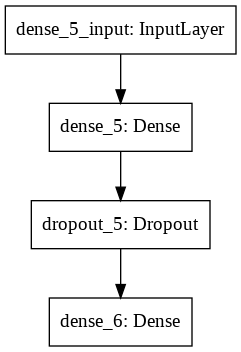

In [0]:
Draw.plot_model(model_1)

In [0]:
history = model_1.fit(linear_sum_space_train, y_train, epochs=20)

Epoch 1/20
15552/15552 [==============================] - 2s 112us/step - loss: 0.2237 - accuracy: 0.9106
Epoch 2/20
15552/15552 [==============================] - 2s 106us/step - loss: 0.1883 - accuracy: 0.9242
Epoch 3/20
15552/15552 [==============================] - 2s 104us/step - loss: 0.1836 - accuracy: 0.9260
Epoch 4/20
15552/15552 [==============================] - 2s 104us/step - loss: 0.1814 - accuracy: 0.9269
Epoch 5/20
15552/15552 [==============================] - 2s 105us/step - loss: 0.1800 - accuracy: 0.9278
Epoch 6/20
15552/15552 [==============================] - 2s 103us/step - loss: 0.1797 - accuracy: 0.9280
Epoch 7/20
15552/15552 [==============================] - 2s 102us/step - loss: 0.1788 - accuracy: 0.9284
Epoch 8/20
15552/15552 [==============================] - 2s 102us/step - loss: 0.1790 - accuracy: 0.9291
Epoch 9/20
15552/15552 [==============================] - 2s 105us/step - loss: 0.1788 - accuracy: 0.9293
Epoch 10/20
15552/15552 [=====================

Metrics on Test set

In [0]:
threshold = 0.5
y_pred_prob = model_1.predict(linear_sum_space_test)
y_true_test = y_test
y_pred = (y_pred_prob> threshold).astype('int')

In [0]:
test_f1_weighted = f1_score(y_true_test, y_pred, average='weighted')
test_f1_micro = f1_score(y_true_test, y_pred, average='micro')
test_f1_macro = f1_score(y_true_test, y_pred, average='macro')
test_f1_samples = f1_score(y_true_test, y_pred, average='samples')
print(f" - test_f1_weighted:  {test_f1_weighted:.5f} - test_f1_samples:  {test_f1_samples:.5f} - test_f1_micro:  {test_f1_micro:.5f} - test_f1_macro: {test_f1_macro:.5f}")

 - test_f1_weighted:  0.47948 - test_f1_samples:  0.50466 - test_f1_micro:  0.50801 - test_f1_macro: 0.36100


* **Concatenation:** Different works have found that a simple concatenation of representations of dif- ferent modalities are good for combining the information. Herein, we concatenated both representations to train the MaxoutMLP architecture.

In [0]:
concatenation_space_train = np.concatenate((bottleneck_features_text_train, bottleneck_visual_features_train), axis=1)
concatenation_space_test = np.concatenate((bottleneck_features_text_test, bottleneck_visual_features_test), axis=1)

In [0]:
model_2 = Sequential()
model_2.add(Dense(128, input_dim=1024, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(23, activation='sigmoid'))

model_2.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

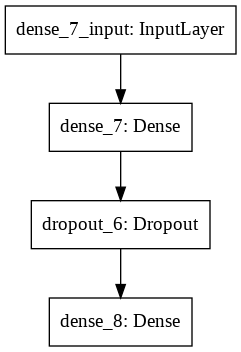

In [0]:
Draw.plot_model(model_2)

In [0]:
history = model_2.fit(concatenation_space_train, y_train, epochs=20)

Epoch 1/20
15552/15552 [==============================] - 2s 111us/step - loss: 0.2149 - accuracy: 0.9146
Epoch 2/20
15552/15552 [==============================] - 2s 104us/step - loss: 0.1857 - accuracy: 0.9246
Epoch 3/20
15552/15552 [==============================] - 2s 104us/step - loss: 0.1810 - accuracy: 0.9269
Epoch 4/20
15552/15552 [==============================] - 2s 105us/step - loss: 0.1798 - accuracy: 0.9282
Epoch 5/20
15552/15552 [==============================] - 2s 104us/step - loss: 0.1789 - accuracy: 0.9284
Epoch 6/20
15552/15552 [==============================] - 2s 107us/step - loss: 0.1784 - accuracy: 0.9293
Epoch 7/20
15552/15552 [==============================] - 2s 116us/step - loss: 0.1781 - accuracy: 0.9292
Epoch 8/20
15552/15552 [==============================] - 2s 116us/step - loss: 0.1781 - accuracy: 0.9297
Epoch 9/20
15552/15552 [==============================] - 2s 115us/step - loss: 0.1775 - accuracy: 0.9300
Epoch 10/20
15552/15552 [=====================

Metrics on Test set 


In [0]:
threshold = 0.5
y_pred_prob = model_2.predict(concatenation_space_test)
y_true_test = y_test
y_pred = (y_pred_prob> threshold).astype('int')

In [0]:
test_f1_weighted = f1_score(y_true_test, y_pred, average='weighted')
test_f1_micro = f1_score(y_true_test, y_pred, average='micro')
test_f1_macro = f1_score(y_true_test, y_pred, average='macro')
test_f1_samples = f1_score(y_true_test, y_pred, average='samples')
print(f" - test_f1_weighted:  {test_f1_weighted:.5f} - test_f1_samples:  {test_f1_samples:.5f} - test_f1_micro:  {test_f1_micro:.5f} - test_f1_macro: {test_f1_macro:.5f}")

 - test_f1_weighted:  0.47590 - test_f1_samples:  0.50564 - test_f1_micro:  0.50797 - test_f1_macro: 0.35105


## 3.2 Evaluate and analyze the results. 
Compare the results with the ones of the two previous questions. Find a recent paper (2019-2020) that uses the same dataset. Compare your results against the results reported in the original and the new paper.

| Modality   |                | Representation | f1_weighted | f1_samples | f1_micro | f1_macro |
|------------|----------------|----------------|-------------|------------|----------|----------|
| Multimodal | Arevalo et al. | GMU            | 0.617       | 0.630      | 0.630    | 0.541    |
|            |                | Linear_sum     | 0.600       | 0.607      | 0.607    | 0.530    |
|            |                | Concatenate    | 0.597       | 0.605      | 0.606    | 0.521    |
|            |                | AVG_probs      | 0.604       | 0.616      | 0.615    | 0.491    |
| Multimodal | Ours           | Linear_sum     |  0.47948           |     0.50466       |     0.50801     |      0.36100    |
|            |                | Concatenate    |     0.47590        |     0.50564       |     0.50797     |    0.35105      |
|            |                | AVG_probs      |       0.37623      |       0.37255     |      0.40411    |     0.24904     |

**Discuss:** Our approaches for multimodal come close but did not improve the ones reported in the paper. This could be influenced by the Visual representation that we had was not robust enough to have more meaningful features. A deeper approach in the concatenation migth benefit also and Additional fine tuning and more computing time could benefit representation and further improve results. 

**Recent Papers:**


* D. Kiela, S. Bhooshan, H. Firooz, and D. Testuggine, **“Supervised Multimodal Bitransformers for Classifying Images and Text,” 2019.**

| Modality       |            | f1_macro | f1_micro |
|----------------|------------|----------|----------|
| Arevalo et al. | GMU        | 54.1     | 63.0     |
| Kiela et al.   | ConcatBow  | 43.4     | 53.3     |
|                | ConcatBert | 60.6     | 66.1     |
|                | MMBT       | **61.1**     | **66.4**     |

In this paper extended bidirectional transformer such as BERT creating multimodal bitransformers  with better results than than the original paper. 

#References

Part of the code and dataset was taken from: \\
https://github.com/johnarevalo/gmu-mmimdb \\
Arevalo, J., Solorio, T., Montes-y-Gómez, M., & González, F. A. (2017). Gated multimodal units for information fusion. In: 5th International conference on learning representations 2017 workshop

\\
The solution of problem 1) was developed based on the explanation given by \\
https://godatadriven.com/blog/keras-multi-label-classification-with-imagedatagenerator/

\\
The solution of problem 2) was developed based on the explanation given by \\
https://towardsdatascience.com/reading-between-the-layers-lstm-network-7956ad192e58 
 
 part of the code for preprocessing is based on
https://jdvala.github.io/blog.io/thesis/2018/05/25/RNN-Sequence-Classification-with-modifications.html

and part of the code for the architecture network is based on
https://www.kaggle.com/eashish/bidirectional-gru-with-convolution

and
https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge?scriptVersionId=2302720